<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

### Task 1: Import Packages and Functions

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.2.0


### Task 2: Load and Explore Data

In [5]:
# Load data
train=pd.read_csv('train.csv').fillna(' ')
train.sample(10,random_state=1)
# test=pd.read_csv('')

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [6]:
X=train.comment_text
# X.head()
y=train.toxic
y.head()

0    0
1    0
2    0
3    0
4    0
Name: toxic, dtype: int64

In [7]:
# View few toxic comments


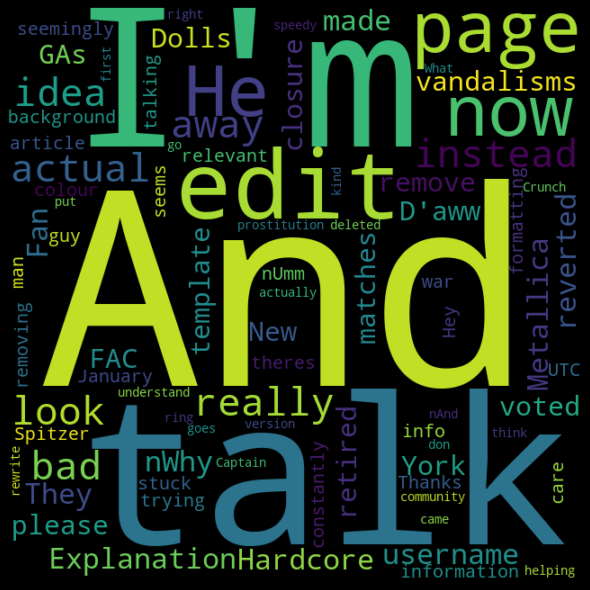

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train['comment_text'].loc[train['toxic']==0].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

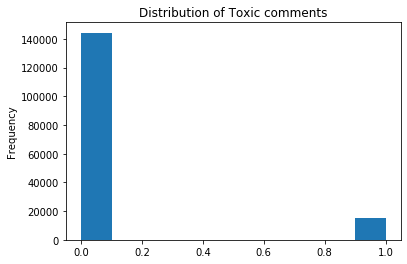

In [9]:
# Plot frequency of toxic comments
train['toxic'].plot(kind='hist',title='Distribution of Toxic comments')

In [10]:
train['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [11]:
max_features=20000# most frequent words
max_text_length=400

In [12]:
# Tokenizer class aloow us to vectorize the text corpus by turning each text into sequence of 
#integers where each integer being the index of a token in a dictionary and the value is the world itself

x_tokenizer=text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(X))
x_tokenized =x_tokenizer.texts_to_sequences(X)
#now pad the sequence so that each document/senetence have the same length 
x_train_val=sequence.pad_sequences(x_tokenized,maxlen=max_text_length)


### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [13]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

embedding_dim=100
embedding_index=dict()
f=open('glove.6B.100d.txt')
for line in f:
    values = line.split()#split the flie into lines
    word =  values[0]#from first line first value i.e, string  and word
    coefs=np.asarray(values[1:],dtype='float32')
    embedding_index[word]=coefs
f.close()
print(f'Found {len(embedding_index)} word vectors. ')
    

Found 400000 word vectors. 


In [14]:
embedding_matrix=np.zeros((max_features,embedding_dim))
for word,index in x_tokenizer.word_index.items():
    if index> max_features-1:
        break
    else:
        embedding_vector=embedding_index.get(word)#get numerical representation of that words
        if embedding_vector is not None:# if true it means words not found in embedding_index will all be zeros
            embedding_matrix[index]=embedding_vector
            
            
        
        

### Task 5: Create the Embedding Layer

In [15]:
model = Sequential()
model.add(Embedding(max_features,embedding_dim,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),trainable=False))
model.add(Dropout(0.2))


### Task 6: Build the Model

In [16]:
filters=250
kernel_size=3
hidden_dims=250


In [17]:
#conv1d
model.add(Conv1D(filters,
                kernel_size,
                padding='valid'))#valid means we not padded data it already padded
model.add(MaxPooling1D())
model.add(Conv1D(filters,5,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D()) #this layer simply downsamples input representation by taking max value over the time dimension
model.add(Dense(hidden_dims,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Task 7: Train Model

In [20]:
x_train,x_val,y_train,y_val=train_test_split(x_train_val,y,test_size=0.15,random_state=1)

In [21]:
%%time
batch_size=32
epochs=3
model.fit(x_train,y_train,
         batch_size=batch_size,
         epochs=3,
         validation_data=(x_val,y_val))

Epoch 1/3
4239/4239 [==============================] - 83s 20ms/step - loss: 0.1542 - accuracy: 0.9444 - val_loss: 0.1249 - val_accuracy: 0.9519
Epoch 2/3
4239/4239 [==============================] - 82s 19ms/step - loss: 0.1327 - accuracy: 0.9507 - val_loss: 0.1208 - val_accuracy: 0.9542
Epoch 3/3
4239/4239 [==============================] - 82s 19ms/step - loss: 0.1241 - accuracy: 0.9543 - val_loss: 0.1197 - val_accuracy: 0.9554
CPU times: user 3min 27s, sys: 38.5 s, total: 4min 5s
Wall time: 4min 37s


In [22]:
test=pd.read_csv('test.csv')
x_test=test.comment_text

In [23]:
X_test_tokenized=x_tokenizer.texts_to_sequences(x_test)

### Task 8: Evaluate Model

In [25]:
X_testing=sequence.pad_sequences(X_test_tokenized,maxlen=max_text_length)

In [27]:
y_testing=model.predict(X_testing,verbose=1,batch_size=32)
y_testing.shape

4787/4787 [==============================] - 35s 7ms/step


(153164, 1)

In [28]:
y_testing[0]

array([0.9943402], dtype=float32)

##### 

In [29]:
test['Toxic']=['not toxic' if x<0.5 else 'toxic' for x in y_testing]
test[['comment_text','Toxic']].head(20)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,not toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
